In [146]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
from lazypredict.Supervised import LazyClassifier

## Reading ##

In [62]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [63]:
test_data_id = test_data['PassengerId']

In [64]:
drop_cols = ["PassengerId", "Name", "Ticket"]
cat_cols = ["Pclass", "Sex", "Embarked"]
num_cols = ["Age", "SibSp", "Parch", "Fare"]
special_cols = ["Survived", "Cabin"]

In [65]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Feature engineering ##

Missing values

In [66]:
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].median())

train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])
test_data['Embarked'] = test_data['Embarked'].fillna(test_data['Embarked'].mode()[0])

test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].median())

In [67]:
train_data['Cabin'] = train_data['Cabin'].fillna('U').str[0]
test_data['Cabin'] = test_data['Cabin'].fillna('U').str[0]

New features

In [68]:
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1

train_data['IsAlone'] = (train_data['FamilySize'] == 1).astype(int)
test_data['IsAlone'] = (test_data['FamilySize'] == 1).astype(int)

train_data['Title'] = train_data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

train_data['FarePerPerson'] = train_data['Fare'] / train_data['FamilySize']
test_data['FarePerPerson'] = test_data['Fare'] / test_data['FamilySize']

In [69]:
bins = [0, 12, 19, 35, 50, float('inf')]
labels = ['Kids', 'Teens', 'Young Adults', 'Adults', 'Olds']

train_data['AgeGroup'] = pd.cut(train_data['Age'], bins=bins, labels=labels, right=False)
test_data['AgeGroup'] = pd.cut(test_data['Age'], bins=bins, labels=labels, right=False)

Transforming

In [70]:
train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1}).astype(int)
test_data['Sex'] = test_data['Sex'].map({'male': 0, 'female': 1}).astype(int)

train_data = pd.get_dummies(train_data, columns=['Embarked', 'AgeGroup'])
test_data = pd.get_dummies(test_data, columns=['Embarked', 'AgeGroup'],)

In [71]:
title_mapping = {
                 'Mr': 1, 
                 'Miss': 2, 
                 'Mrs': 3, 
                 'Master': 4, 
                 'Dr': 5, 
                 'Rev': 6, 
                 'Col': 7, 
                 'Major': 8,
                 'Mlle': 9, 
                 'Countess': 10, 
                 'Ms': 11, 
                 'Lady': 12, 
                 'Jonkheer': 13, 
                 'Don': 14, 
                 'Dona': 15,
                 'Mme': 16, 
                 'Capt': 17, 
                 'Sir': 18 
                }

train_data['Title'] = train_data['Title'].map(title_mapping).fillna(0).astype(int)
test_data['Title'] = test_data['Title'].map(title_mapping).fillna(0).astype(int)

StandartScaler

In [72]:
scaler = StandardScaler()
new_num_cols = ['Age', 'Fare', 'FarePerPerson']

train_data[new_num_cols] = scaler.fit_transform(train_data[new_num_cols])
test_data[new_num_cols] = scaler.transform(test_data[new_num_cols])

LabelEncoder

In [73]:
encoder = LabelEncoder()

train_data['Sex'] = encoder.fit_transform(train_data['Sex'])
test_data['Sex'] = encoder.transform(test_data['Sex'])

train_data['Cabin'] = encoder.fit_transform(train_data['Cabin'])
test_data['Cabin'] = encoder.transform(test_data['Cabin'])

Drop

In [74]:
to_drop = drop_cols 
train_data = train_data.drop(columns=to_drop)
test_data = test_data.drop(columns=to_drop)

In [75]:
train_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,FamilySize,IsAlone,Title,FarePerPerson,Embarked_C,Embarked_Q,Embarked_S,AgeGroup_Kids,AgeGroup_Teens,AgeGroup_Young Adults,AgeGroup_Adults,AgeGroup_Olds
0,0,3,0,-0.565736,1,0,-0.502445,8,2,0,1,-0.454798,False,False,True,False,False,True,False,False
1,1,1,1,0.663861,1,0,0.786845,2,2,0,3,0.438994,True,False,False,False,False,False,True,False
2,1,3,1,-0.258337,0,0,-0.488854,8,1,1,2,-0.334757,False,False,True,False,False,True,False,False
3,1,1,1,0.433312,1,0,0.420730,2,2,0,3,0.185187,False,False,True,False,False,False,True,False
4,0,3,0,0.433312,0,0,-0.486337,8,1,1,1,-0.331267,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,-0.181487,0,0,-0.386671,8,1,1,6,-0.193081,False,False,True,False,False,True,False,False
887,1,1,1,-0.796286,0,0,-0.044381,1,1,1,2,0.281499,False,False,True,False,False,True,False,False
888,0,3,1,-0.104637,1,2,-0.176263,8,4,0,2,-0.392335,False,False,True,False,False,True,False,False
889,1,1,0,-0.258337,0,0,-0.044381,2,1,1,1,0.281499,True,False,False,False,False,True,False,False


## Modeling ##

Data separation

In [76]:
X = train_data.copy()
y = X.pop("Survived")

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Choosing models

In [152]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test), lr.score(X_train, y_train)

(0.8044692737430168, 0.8160112359550562)

In [79]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn.score(X_test, y_test), knn.score(X_train, y_train)

(0.8044692737430168, 0.8581460674157303)

In [80]:
gb = GaussianNB()
gb.fit(X_train, y_train)
gb.score(X_test, y_test), gb.score(X_train, y_train)

(0.7318435754189944, 0.7443820224719101)

In [109]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
ada.score(X_test, y_test), ada.score(X_train, y_train)

(0.7988826815642458, 0.8455056179775281)

In [110]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_test, y_test), rf.score(X_train, y_train)

(0.8212290502793296, 0.9845505617977528)

In [111]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test), xgb.score(X_train, y_train)

(0.8100558659217877, 0.976123595505618)

In [112]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
lgbm.score(X_test, y_test), lgbm.score(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

(0.8379888268156425, 0.9648876404494382)

In [113]:
ext = ExtraTreesClassifier()
ext.fit(X_train, y_train)
ext.score(X_test, y_test), ext.score(X_train, y_train)

(0.8212290502793296, 0.9845505617977528)

In [114]:
svc_model = SVC(probability=True)
svc_model.fit(X_train, y_train)
svc_model.score(X_test, y_test), svc_model.score(X_train, y_train)

(0.8044692737430168, 0.827247191011236)

In [115]:
svc_model_linear = LinearSVC()
svc_model_linear.fit(X_train, y_train)
svc_model_linear.score(X_test, y_test), svc_model_linear.score(X_train, y_train)

(0.7932960893854749, 0.8216292134831461)

In [104]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 31/31 [00:01<00:00, 16.96it/s]

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [108]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.83,0.82,0.82,0.83,0.16
RandomForestClassifier,0.82,0.81,0.81,0.82,0.18
XGBClassifier,0.82,0.80,0.80,0.81,0.71
AdaBoostClassifier,0.80,0.79,0.79,0.80,0.13
LGBMClassifier,0.80,0.79,0.79,0.80,0.07
SVC,0.80,0.79,0.79,0.80,0.03
KNeighborsClassifier,0.80,0.79,0.79,0.80,0.03
CalibratedClassifierCV,0.80,0.79,0.79,0.80,0.04
LinearSVC,0.80,0.79,0.79,0.80,0.02


Feature importances

In [89]:
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': ada.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df)

                  Feature  Importance
1                     Sex    0.160555
2                     Age    0.154458
9                   Title    0.148224
5                    Fare    0.136906
10          FarePerPerson    0.136103
0                  Pclass    0.048974
6                   Cabin    0.048224
7              FamilySize    0.045624
3                   SibSp    0.026874
4                   Parch    0.015360
13             Embarked_S    0.013044
11             Embarked_C    0.011345
16  AgeGroup_Young Adults    0.011200
14          AgeGroup_Kids    0.009441
8                 IsAlone    0.008524
17        AgeGroup_Adults    0.008060
18          AgeGroup_Olds    0.005976
12             Embarked_Q    0.005720
15         AgeGroup_Teens    0.005390


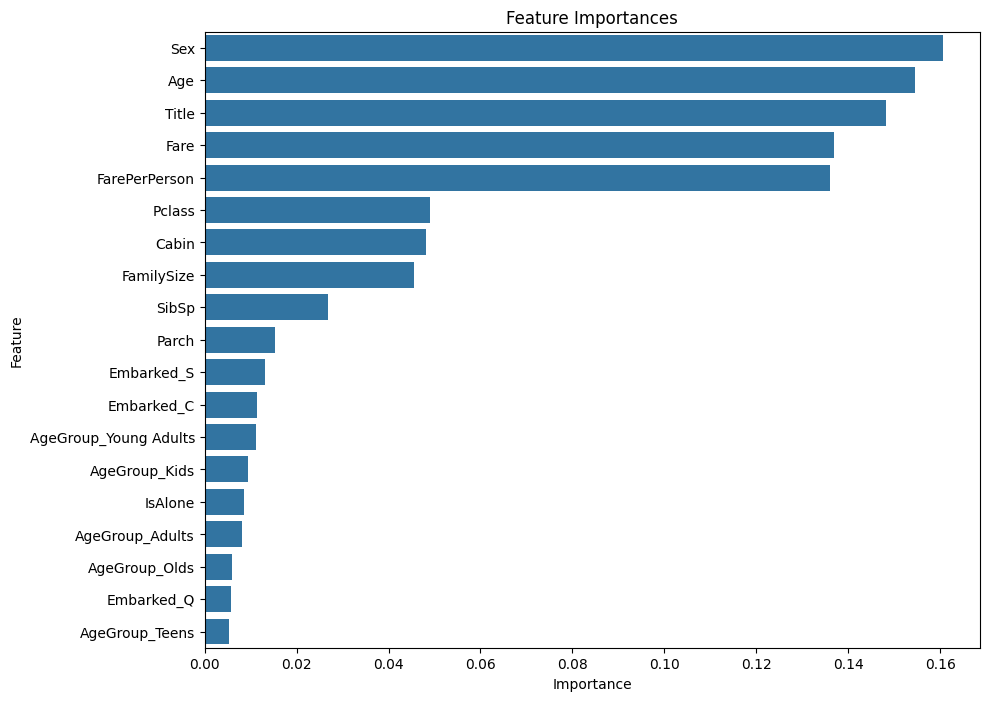

In [90]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()

## Tuning ##

Random Forest

In [118]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier()

grid_search_rf = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=3, 
    n_jobs=-1, 
    verbose=2, 
    scoring='accuracy'
)

In [119]:
grid_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 972 candidates, totalling 2916 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [120]:
best_rf = grid_search_rf.best_estimator_
grid_search_rf.best_params_, grid_search_rf.best_score_

({'bootstrap': True,
  'max_depth': 40,
  'max_features': 'sqrt',
  'min_samples_leaf': 2,
  'min_samples_split': 5,
  'n_estimators': 100},
 np.float64(0.8342729496862037))

In [122]:
best_rf.score(X_test, y_test), best_rf.score(X_train, y_train),

(0.8268156424581006, 0.9157303370786517)

LightGBM

In [124]:
param_grid = {
    'num_leaves': [31, 40, 50],
    'max_depth': [-1, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'min_child_samples': [20, 30, 40],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

lgbm = LGBMClassifier()

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='accuracy'
)

In [125]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [-1, 10, 20, 30],
                         'min_child_samples': [20, 30, 40],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [31, 40, 50],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy', verbose=2)

In [126]:
grid_search.best_params_, grid_search.best_score_

({'colsample_bytree': 0.9,
  'learning_rate': 0.01,
  'max_depth': -1,
  'min_child_samples': 30,
  'n_estimators': 300,
  'num_leaves': 31,
  'subsample': 0.8},
 np.float64(0.8314659197012139))

In [127]:
best_lgbm = grid_search.best_estimator_

In [128]:
best_lgbm.score(X_test, y_test), best_lgbm.score(X_train, y_train)

(0.8268156424581006, 0.8735955056179775)

ExtraTrees

In [141]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

etc = ExtraTreesClassifier(bootstrap=False)

grid_search = GridSearchCV(
    estimator=etc, 
    param_grid=param_grid, 
    cv=3, 
    n_jobs=-1, 
    verbose=2, 
    scoring='accuracy'
)

In [142]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 810 candidates, totalling 2430 fits


GridSearchCV(cv=3, estimator=ExtraTreesClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30, 40, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='accuracy', verbose=2)

In [143]:
best_etc = grid_search.best_estimator_

In [145]:
best_etc.score(X_test, y_test), best_etc.score(X_train, y_train)

(0.8156424581005587, 0.8693820224719101)

## Ensembling ##

In [202]:
lr.fit(X_train, y_train)

LogisticRegression()

Opt #1

In [203]:
estimators = [
    ('rf', best_rf),
    ('lgbm', best_lgbm),
    ('ext', best_etc)
]

stacking_model_forest = StackingClassifier(
    estimators=estimators,
    final_estimator=lr,
    cv=5,
)

In [204]:
stacking_model_forest.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 360
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=40,
                                                       min_samples_leaf=2,
                                                       min_samples_split=5)),
                               ('lgbm',
                                LGBMClassifier(colsample_bytree=0.9,
                                               learning_rate=0.01,
                                               min_child_samples=30,
                                               n_estimators=300,
                                               subsample=0.8)),
                               ('ext',
                                ExtraTreesClassifier(max_depth=20,
                                                     min_samples_leaf=4,
                                                     min_samples_split=5))],
                   final_estimator=LogisticRegression())

In [205]:
stacking_model_forest.score(X_test, y_test), stacking_model_forest.score(X_train, y_train)

(0.8268156424581006, 0.898876404494382)

In [206]:
y_pred = stacking_model_forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       105
           1       0.81      0.76      0.78        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



Opt #2

In [208]:
stacking_model_lr_ext = StackingClassifier(
    estimators=[('lr', lr)],
    final_estimator=best_etc,
    cv=5
)

In [209]:
stacking_model_lr_ext.fit(X_train, y_train)

StackingClassifier(cv=5, estimators=[('lr', LogisticRegression())],
                   final_estimator=ExtraTreesClassifier(max_depth=20,
                                                        min_samples_leaf=4,
                                                        min_samples_split=5))

In [210]:
stacking_model_lr_ext.score(X_test, y_test), stacking_model_lr_ext.score(X_train, y_train)

(0.8100558659217877, 0.8188202247191011)

Opt #3

In [211]:
stacking_model_lr_lgbm = StackingClassifier(
    estimators=[('lr', lr)],
    final_estimator=best_lgbm,
    cv=5
)

In [212]:
stacking_model_lr_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 238
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

StackingClassifier(cv=5, estimators=[('lr', LogisticRegression())],
                   final_estimator=LGBMClassifier(colsample_bytree=0.9,
                                                  learning_rate=0.01,
                                                  min_child_samples=30,
                                                  n_estimators=300,
                                                  subsample=0.8))

In [213]:
stacking_model_lr_lgbm.score(X_test, y_test), stacking_model_lr_lgbm.score(X_train, y_train)

(0.8100558659217877, 0.8160112359550562)

## Making predictions ##

In [220]:
stacking_model_forest.fit(X, y)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 410
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

StackingClassifier(cv=5,
                   estimators=[('rf',
                                RandomForestClassifier(max_depth=40,
                                                       min_samples_leaf=2,
                                                       min_samples_split=5)),
                               ('lgbm',
                                LGBMClassifier(colsample_bytree=0.9,
                                               learning_rate=0.01,
                                               min_child_samples=30,
                                               n_estimators=300,
                                               subsample=0.8)),
                               ('ext',
                                ExtraTreesClassifier(max_depth=20,
                                                     min_samples_leaf=4,
                                                     min_samples_split=5))],
                   final_estimator=LogisticRegression())

In [214]:
stacking_model_lr_lgbm.fit(X, y)


[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

StackingClassifier(cv=5, estimators=[('lr', LogisticRegression())],
                   final_estimator=ExtraTreesClassifier(max_depth=20,
                                                        min_samples_leaf=4,
                                                        min_samples_split=5))

In [223]:
stacking_model_lr_ext.fit(X, y)

StackingClassifier(cv=5, estimators=[('lr', LogisticRegression())],
                   final_estimator=ExtraTreesClassifier(max_depth=20,
                                                        min_samples_leaf=4,
                                                        min_samples_split=5))

In [221]:
y_pred = lr.predict(test_data)

In [222]:
pd.DataFrame({
    "PassengerID": test_data_id,
    "Survived": y_pred
}).to_csv("lr.csv", index=False)